# **Esempio 3. Implementazione di un percettrone per la catalogazione di acidi in forti e deboli**

## **Obiettivo**
In questo esempio si implementa un semplice percettrone che verrà addestrato per riconoscere se un acido è forte o debole, in base ai descrittori selezionati.

Il percettrone è un algoritmo bio-ispirato per la catalogazione binaria. Tale catalogazione viene effettuata calcolado una attivazione, $a$ che può essere positiva o negativa, rispetto a una soglia ($b$). Dati i descrittori ($\mathbf{X}\in\Re^D$) e l'etichetta ($y=\pm1$) a loro assocciata, l'algortimo cerca la soglia e i pesi $\mathbf{w}=[w_1,\,\,w_2,\,\dots,\,\,w_D]^\textrm{tr}$ tale per cui l'attivazione sia calcolata come

\begin{equation}
a=\mathbf{w}\cdot\mathbf{X}+b
\end{equation}

I pesi vengono calcolati reitirando `Niter` volte la procedura di addestrameento in maniera sequenziale su tutti gli esempi. Il numero di iterazioni è l'iperparametro dell'algoritmo.

Rispetto agli altri algoritmi visti finora, il percettrone utilizza i descrittori con un peso relativo differente. Questo rende il percettrone meno sensibile all'*overfitting*.

Data la semplicità dell'algoritmo, in questo esempio il percettrone viene direttamente implementato. D'altra parte, si sfrutteranno gli strumenti di `sklearn` per la separazione del dataset e per le metriche.

In [2]:
from sklearn.model_selection import train_test_split # Importa la funzione per il separare il dataset in train e test
from sklearn import metrics # Importa il modulo per le metriche

import pandas as pd
import numpy as np

Per il calcolo dei descrittori si useranno `rdkit` e `mordred`. Se necessario, si installino le librerie.

In [4]:
%%capture
!pip install rdkit
!pip install git+https://github.com/mordred-descriptor/mordred

Con la cella che segue si importano le librerie.

In [5]:
from rdkit import Chem

import mordred
from mordred import Calculator
from mordred import HydrogenBond, Polarizability

# **Implementazione del percettrone**
L'algoritmo dovrà prendere in input la lista di esempi di addestramento e il numero di iterazioni (iperparametro del modello) e fornisce in output i pesi e la soglia.

In [6]:
# Addestramento del percettrone
def binary_perceptron(examples, Niter):

  # Ottiene il numero di esmepi e il numero di descrittori
  s = examples.shape
  D = s[0]
  nX = s[1] - 1

  # Inizializza a 0 l'array dei pesi e la soglia
  w = np.zeros(nX)
  b = 0.0

  # Ciclo sulle iterazioni
  for i in range (0, Niter):
    # Ciclo sugli esempi
    for n in range (0, D):
      # Calcola l'attivazione
      a = b + np.matmul(np.transpose(w), examples[n,0:nX])
      # Aggiorna i pesi se l'attivazione è opposta all'etichetta
      if (a * examples[n, nX] <= 0):
        w = w + examples[n, nX] * examples[n, 0:nX]
        b = b + examples[n, nX]

  return w, b

# Utilizzo del percettrone
def test_binary_perceptron(X, w, b):
  a = b + np.matmul(np.transpose(w), X)
  return np.sign(a)

## **Dataset**
La cella che segue carica dall'URL indicato la tabella con tre colonne: 1) specie chimica, 2) valore della $pk_\textrm{a}$ e 3) catalogazione se l'acido è forte ($pk_\textrm{a} < 0$) o debole ($pk_\textrm{a} \ge 0$). Nelle cella di codice che segue viene caricato il file come `DataFrame` di `pandas`.

In [3]:
url = 'https://drive.google.com/file/d/12gTXH9xqAarMV1hf8gAtmdTwyBqK7hOW/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]

data = pd.read_table(url, encoding='windows-1252', delimiter=';')

display(data)

specie        pka  forza
0       OCl(=O)(=O)=O -10.000000      1
1                [IH]  -9.505150      1
2               [BrH]  -9.000000      1
3               [ClH]  -6.113943      1
4         OS(=O)(=O)O  -3.000000      1
5       O[N+]([O-])=O  -1.380211      1
6        OC(=O)C(=O)O   1.267606     -1
7             OS(O)=O   1.886057     -1
8      OS([O-])(=O)=O   2.000000     -1
9          OP(=O)(O)O   2.148742     -1
10               ON=O   3.142668     -1
11               [FH]   3.180456     -1
12             C(=O)O   3.744727     -1
13     OC(=O)c1ccccc1   4.200659     -1
14  C(=O)(C(=O)[O-])O   4.267606     -1
15            CC(=O)O   4.744727     -1
16      [O-]C([O-])=O   6.356547     -1
17              [SH2]   6.958607     -1
18      OP(=O)(O)[O-]   7.200659     -1
19              [SH-]   2.207608     -1
20                OCl   7.537602     -1
21                C#N   9.207608     -1
22             [NH4+]   9.236572     -1
23             OB(O)O  10.000000     -1
24         OC([O-])=O  10.327902     -1
25   [O-]P(=O)(O)[O-]  12.376751     -1
26        B(O)(O)[O-]  12.744727     -1
27     B(O)([O-])[O-]  13.795880     -1

Usiamo il modulo `rdkit.Chem` per interpretare le stringhe SMILES del dataset.

In [7]:
smiles_str = data.specie.astype(str).to_list()
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_str]

Rappresentiamo le molecole usando il valore della $pk_\textrm{a}$ come legenda.

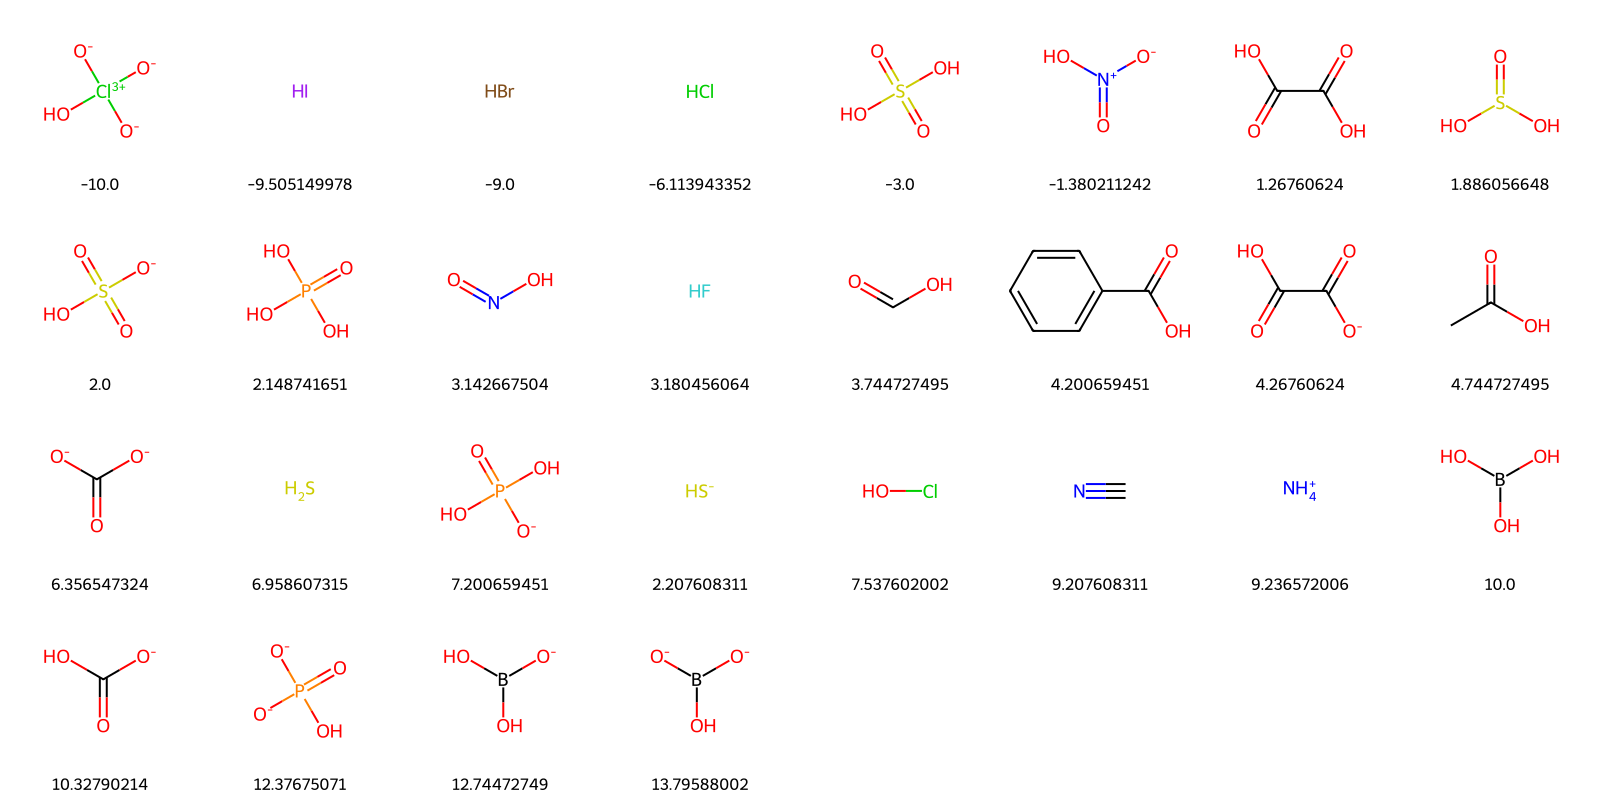

In [8]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, molsPerRow=8,subImgSize=(200,200), legends=[str(x) for x in data['pka']])

Nella cella seguente viene impostato il motore di `mordered` a calcolare i descrittori scelti e poi il calcolatore viene applicato alla lista `mols`. I descrittori appena calcolati vengono salvati nel `DataFrame` chiamato `descr`. Il risultato viene rappresentato come tabella. I termini apol e bpol indicano, rispettivamente, la polarizzabilità degli atomi e dei legami. Le variabili nHBAcc e nHBDon contano, rispettivamente, gli atomi accettori e donatori di legami H.

In [9]:
# Crea il calcolatore di descrittori
calc = Calculator()

# Aggiunge i descrittori da calcolare
calc.register(Polarizability)
calc.register(HydrogenBond)

# Crea il DataFrame con i descrittori
descr = calc.pandas(mols)
display(descr)

100%|██████████| 28/28 [00:00<00:00, 190.69it/s]


apol       bpol  nHBAcc  nHBDon
0    6.054793   5.647207       4       1
1    6.016793   4.683207       0       0
2    3.716793   2.383207       0       0
3    2.846793   1.513207       0       0
4    7.441586   8.662414       2       2
5    4.172793   1.029207       2       1
6    7.881586   3.742414       2       2
7    6.639586   6.564414       1       2
8    6.774793   8.527207       3       1
9    8.838379  11.717621       1       3
10   3.370793   0.731207       2       1
11   1.223793   0.109793       0       0
12   4.607586   2.874414       1       1
13  17.294758   6.887242       1       1
14   7.214793   3.607207       3       1
15   7.611172   4.880828       1       1
16   4.076000   2.604000       3       0
17   4.233586   4.466414       0       0
18   8.171586  11.582414       2       2
19   3.566793   2.233207       1       0
20   3.648793   1.513207       1       1
21   3.436793   1.573207       1       0
22   3.767172   1.732828       0       1
23   7.436379   7.089621       3       3
24   4.742793   2.739207       2       1
25   7.504793  11.447207       3       1
26   6.769586   6.954414       3       2
27   6.102793   6.819207       3       1

Generiamo ora un nuovo DataFrame mettendo assieme il contenuto del dataset iniziale e i descrittori appena calcolati.

In [10]:
data2 = data.copy(deep = True)
data2.insert(1, 'apol', descr['apol'])
data2.insert(2, 'bpol', descr['bpol'])
data2.insert(3, 'HA', descr['nHBAcc'])
data2.insert(4, 'HD', descr['nHBDon'])
display(data2)


specie       apol       bpol  HA  HD        pka  forza
0       OCl(=O)(=O)=O   6.054793   5.647207   4   1 -10.000000      1
1                [IH]   6.016793   4.683207   0   0  -9.505150      1
2               [BrH]   3.716793   2.383207   0   0  -9.000000      1
3               [ClH]   2.846793   1.513207   0   0  -6.113943      1
4         OS(=O)(=O)O   7.441586   8.662414   2   2  -3.000000      1
5       O[N+]([O-])=O   4.172793   1.029207   2   1  -1.380211      1
6        OC(=O)C(=O)O   7.881586   3.742414   2   2   1.267606     -1
7             OS(O)=O   6.639586   6.564414   1   2   1.886057     -1
8      OS([O-])(=O)=O   6.774793   8.527207   3   1   2.000000     -1
9          OP(=O)(O)O   8.838379  11.717621   1   3   2.148742     -1
10               ON=O   3.370793   0.731207   2   1   3.142668     -1
11               [FH]   1.223793   0.109793   0   0   3.180456     -1
12             C(=O)O   4.607586   2.874414   1   1   3.744727     -1
13     OC(=O)c1ccccc1  17.294758   6.887242   1   1   4.200659     -1
14  C(=O)(C(=O)[O-])O   7.214793   3.607207   3   1   4.267606     -1
15            CC(=O)O   7.611172   4.880828   1   1   4.744727     -1
16      [O-]C([O-])=O   4.076000   2.604000   3   0   6.356547     -1
17              [SH2]   4.233586   4.466414   0   0   6.958607     -1
18      OP(=O)(O)[O-]   8.171586  11.582414   2   2   7.200659     -1
19              [SH-]   3.566793   2.233207   1   0   2.207608     -1
20                OCl   3.648793   1.513207   1   1   7.537602     -1
21                C#N   3.436793   1.573207   1   0   9.207608     -1
22             [NH4+]   3.767172   1.732828   0   1   9.236572     -1
23             OB(O)O   7.436379   7.089621   3   3  10.000000     -1
24         OC([O-])=O   4.742793   2.739207   2   1  10.327902     -1
25   [O-]P(=O)(O)[O-]   7.504793  11.447207   3   1  12.376751     -1
26        B(O)(O)[O-]   6.769586   6.954414   3   2  12.744727     -1
27     B(O)([O-])[O-]   6.102793   6.819207   3   1  13.795880     -1

Qui di seguito viene creata la nuova *scatter matrix* con tutti dati. I punti sono colorati sempre in funzione della catalogazione dell'acido in forte/debole.

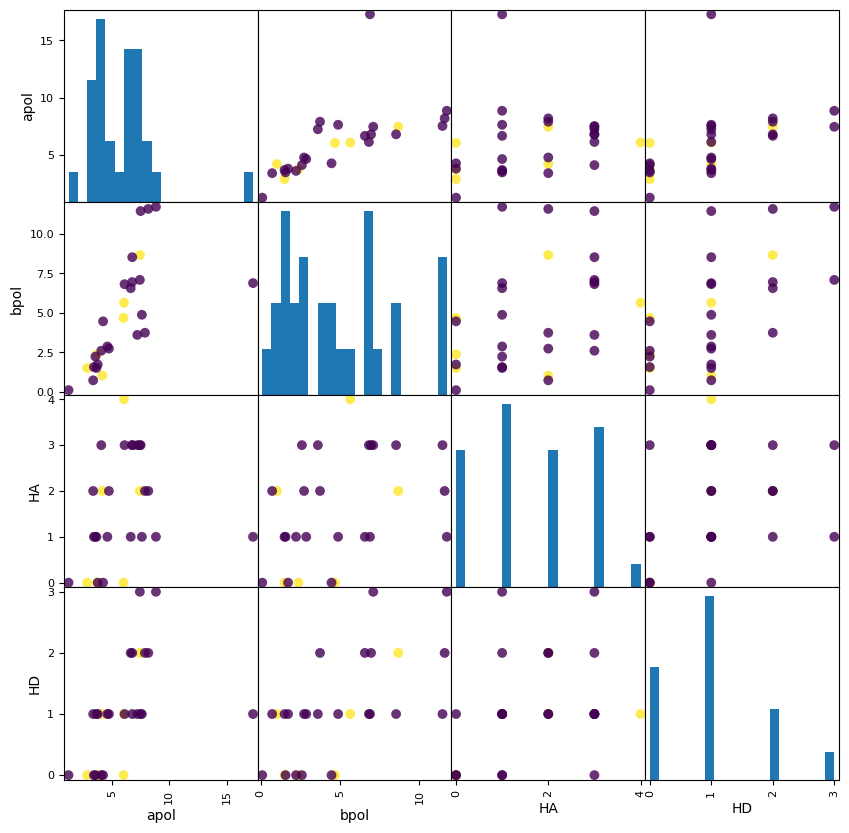

In [11]:
colors = data2['forza'] + 1
grr = pd.plotting.scatter_matrix(data2[['apol', 'bpol', 'HA', 'HD']], c = colors, figsize=(10, 10), marker='o', hist_kwds={'bins': 20}, s=50, alpha=0.8)

## **Addestramento e testing**
Come nell'esempio 1, ci aspettiamo che non ci sia nulla da apprendere nell'usare il valore della $pk_\textrm{a}$ per la catalogazione. Proviamo a usare apol, bpol, HA, e HD.

In [14]:
features = ['apol', 'bpol', 'HA', 'HD']
labels=['forza']

X = data2[features]
y = data2[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training e 30% test

examples = np.concatenate((X_train, y_train), axis=1)
Niter = 100
w, b = binary_perceptron(examples, Niter)

print('Pesi: ', w)
print('Soglia: ', b)

Pesi:  [ -0.184769  -1.444531   8.       -45.      ]
Soglia:  3.0


Si vede che i parametri con maggiore peso sono HA e HD, in particolare il secondo. In quanto segue si testa l'accuratezza del percettrone appena addestrato.

In [13]:
Xnp = X_test.to_numpy()
sX = Xnp.shape
y_pred_np = np.zeros([sX[0], 1])

for i in range(0, len(X_test)):
  y_pred_np[i] = test_binary_perceptron(Xnp[i], w, b)

res = y_test.copy(deep=True)
res.insert(1, 'Predizione', np.round(y_pred_np).astype(int))

display(res)

print("\nAccuracy:", metrics.accuracy_score(y_test, y_pred_np))

forza  Predizione
24     -1          -1
17     -1          -1
19     -1           1
20     -1          -1
14     -1          -1
3       1           1
22     -1          -1
10     -1          -1
21     -1           1


Accuracy: 0.7777777777777778
